In [394]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [407]:
EMOTION_DIR = '/home/fan/Downloads/Emotion/'
FACS_DIR = '/home/fan/Downloads/FACS/'
EMOTION = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise', 'unsure']
AU = ['AU1', 'AU2', 'AU4', 'AU5', 'AU6', 'AU7', 'AU9', 'AU10', 'AU12', 'AU15', 'AU17', 'AU20', 'AU23', 'AU26', 'AU27']

In [408]:
def readEmotion(sub, idx, fn):
    if not os.path.isfile('/home/fan/Downloads/Emotion/{0}/{1}/{2}'.format(sub, idx, fn[0].replace('facs', 'emotion'))):
        return 7
    with open('/home/fan/Downloads/Emotion/{0}/{1}/{2}'.format(sub, idx, fn[0].replace('facs', 'emotion')), 'r') as f:
        emo = f.read()
        
    return int(float(emo.strip())-1)

In [409]:
def readFACS(sub, idx, fn):
    with open('/home/fan/Downloads/FACS/{0}/{1}/{2}'.format(sub, idx, fn[0]), 'r') as f:
        facs = f.readlines()
    au = np.zeros((len(facs), 2))
    for i in range(len(facs)):
        au[i][0] = int(float(facs[i].strip().split()[0]))
        au[i][1] = int(float(facs[i].strip().split()[1]))
        
    return au

In [410]:
def calcRelation():
    relation = np.zeros((len(AU), len(EMOTION)-1))
    for sub in os.listdir(FACS_DIR):
        for idx in os.listdir(FACS_DIR + sub):
            fn = os.listdir(FACS_DIR + sub + '/' + idx)
            emotion = readEmotion(sub, idx, fn)
            facs = readFACS(sub, idx, fn)
            for i in range(len(facs)):
                if 'AU{0}'.format(int(facs[i][0])) in AU and emotion != 7:
                    relation[AU.index('AU{0}'.format(int(facs[i][0]))), emotion] += 1
                    
    return relation

In [411]:
def normalize(matrix):
    for c in range(matrix.shape[1]):
        matrix[:,c] /= np.sum(matrix[:,c])
    matrix[np.isnan(matrix)] = 0
    
    return matrix

In [413]:
def calculateEva(relation, emotion, au):
    p1 = relation[au,emotion]/sum(relation[:,emotion])
    p2 = (sum(relation[au,:]) - relation[au,emotion]) / (np.sum(relation) - sum(relation[:,emotion]))
    
    return p1 - p2

In [425]:
def evaMatrix(idx):
    matrix = calcRelation()
    relation = [[calculateEva(matrix, i, j) for j in range(len(AU))] for i in range(7)]
    evaluation = np.array([sorted(r)[::-1][:idx] for r in relation])
    relation = [[relation[i].index(e) for e in evaluation[i]] for i in range(len(evaluation))]
    
    return evaluation, relation

In [440]:
class LCS:
    
    def __init__(self, relation):
        self.relation = relation
        
    def lcs_sim(self, s1, s2):
        dp = np.zeros((len(s1)+1, len(s2)+1))
        for i in range(len(s1)):
            for j in range(len(s2)):
                if s1[i] == s2[j]:
                    dp[i+1][j+1] = dp[i][j] + 1
                else:
                    dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
        return dp[-1][-1]
        
    def predict(self, s):
        sims = [self.lcs_sim(r, s) for r in self.relation]
        emotion = sims.index(max(sims))
        
        return emotion

In [427]:
class Test:
    def readEmotion(self):
        print(EMOTION[readEmotion('S035', '006', ['S035_006_00000018_emotion.txt'])])
        
    def readFACS(self):
        print(readFACS('S035', '006', ['S035_006_00000018_facs.txt']))

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text yticklabel objects>)

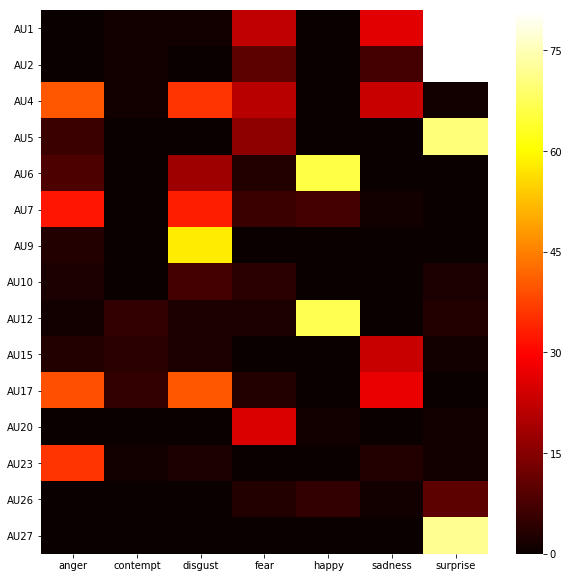

In [428]:
plt.figure(figsize=(10,10))
df = pd.DataFrame(calcRelation(), columns=EMOTION[:-1], index=AU)
ax = sns.heatmap(df, cmap='hot')
plt.yticks(rotation=0)

In [429]:
evaluation, relation = evaMatrix(5)

In [431]:
df2 = pd.DataFrame(evaluation, index=EMOTION[:-1])
df2

,0,1,2,3,4
anger,0.204089,0.147175,0.145382,0.136700,-0.002490
contempt,0.207289,0.194967,0.175334,0.016082,-0.014098
disgust,0.288060,0.117200,0.113734,0.083509,0.026116
fear,0.215323,0.078585,0.078162,0.060537,0.023407
happy,0.445015,0.421072,0.019289,-0.016026,-0.020928
sadness,0.196909,0.153645,0.126098,0.105250,-0.009529
surprise,0.227059,0.222910,0.187733,0.184898,0.019102


In [433]:
df3 = pd.DataFrame(relation, index=EMOTION[:-1])
df3

,0,1,2,3,4
anger,12,10,2,5,7
contempt,8,9,10,12,7
disgust,6,10,5,2,7
fear,11,0,2,3,7
happy,8,4,13,7,11
sadness,9,10,0,2,13
surprise,1,14,3,0,13


In [443]:
relation = [sorted(r) for r in relation]

In [444]:
def evaluation():
    s = 0
    c = 0
    lcs = LCS(relation)
    for sub in os.listdir(FACS_DIR):
        for idx in os.listdir(FACS_DIR + sub):
            fn = os.listdir(FACS_DIR + sub + '/' + idx)
            emotion = readEmotion(sub, idx, fn)
            facs = readFACS(sub, idx, fn)
            facs = [f[0] for f in facs]
            facs = [AU.index('AU{0}'.format(int(f))) for f in facs if 'AU{0}'.format(int(f)) in AU]
            if emotion != 7:
                prediction = lcs.predict(facs)
                if prediction == emotion:
                    c += 1
                    s += 1
                else:
                    s += 1
    print('precision: {0}/{1}'.format(c, s))
evaluation()

precision: 302/327
